### 3.4 Basic building blocks

In [35]:
import math
import torch
from torch import nn
from einops import rearrange, einsum

class Linear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        device: torch.device | None = None,
        dtype: torch.dtype | None = None,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.mean = 0.0
        self.std = math.sqrt(2.0/(self.in_features + self.out_features))
        self.W = nn.init.trunc_normal_(
            torch.empty(self.out_features, self.in_features),
            mean = self.mean,
            std = self.std,
            a = -3.0,
            b = 3.0,    
        )
        self.W = nn.Parameter(self.W)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return einsum(self.W, x, "... d_out d_in, ... d_in -> ... d_out")
        # return self.W@x

In [38]:
linear = Linear(2, 3)
x = torch.randn(2, 2)
x

tensor([[0.0741, 0.5238],
        [0.0866, 0.3265]])

In [39]:
linear(x)

tensor([[ 0.4208,  0.2136,  0.0257],
        [ 0.2149,  0.1543, -0.0349]], grad_fn=<ViewBackward0>)

Total number of values: 6000
Mean: 0.0010
Standard deviation: 0.9900
Min value: -2.9464
Max value: 2.9728


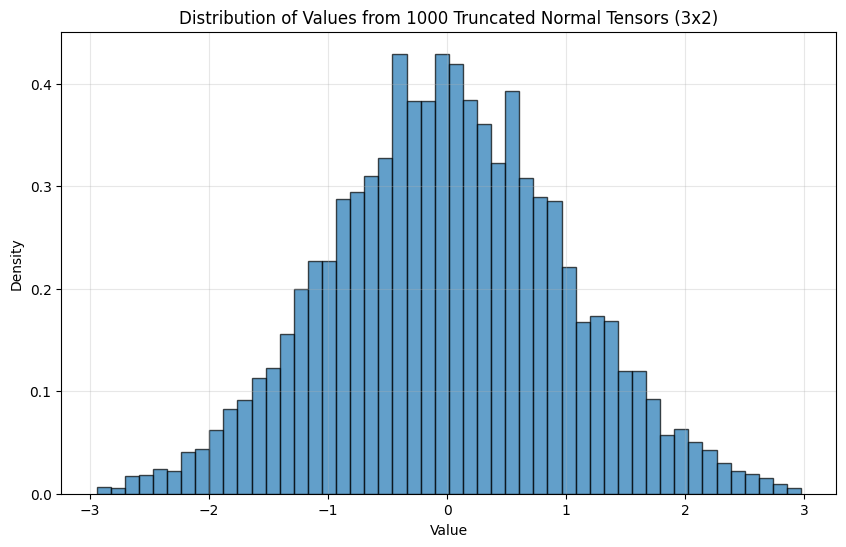

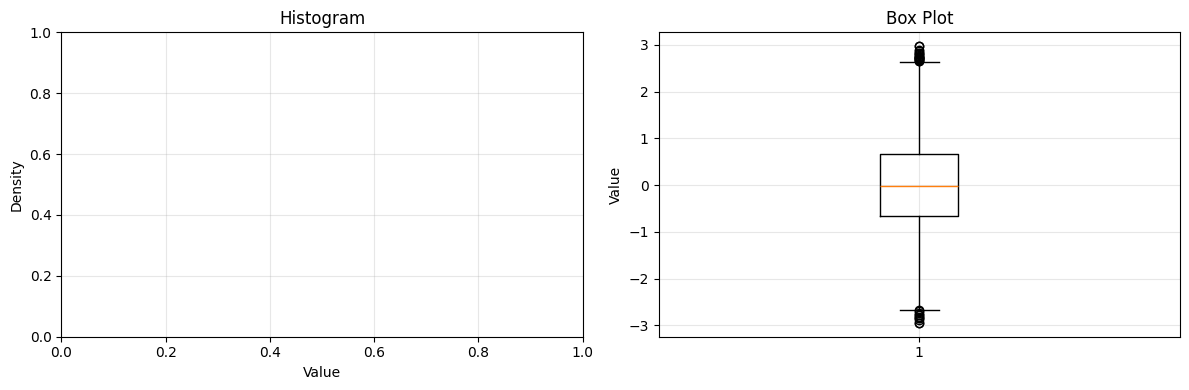

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Collect flattened values from 1000 tensor initializations
all_values = []

for _ in range(1000):
    w = torch.nn.init.trunc_normal_(torch.empty(3, 2), mean=0.0, std=1.0, a=-3.0, b=3.0)
    # Flatten the tensor and add values to our collection
    flattened = w.flatten()
    all_values.extend(flattened.tolist())

# Convert to numpy array for easier analysis
all_values = np.array(all_values)

print(f"Total number of values: {len(all_values)}")
print(f"Mean: {all_values.mean():.4f}")
print(f"Standard deviation: {all_values.std():.4f}")
print(f"Min value: {all_values.min():.4f}")
print(f"Max value: {all_values.max():.4f}")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(all_values, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title('Distribution of Values from 1000 Truncated Normal Tensors (3x2)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.show()

# Also show some statistics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(all_values, vert=True)
plt.title('Box Plot')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Total number of values: 6000
Mean: 0.0088
Standard deviation: 0.8872
Min value: -1.9948
Max value: 1.9981


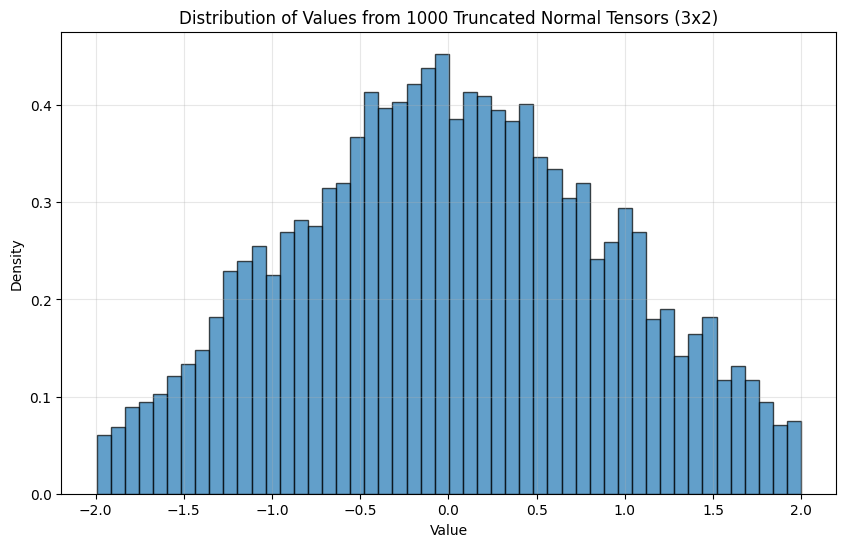

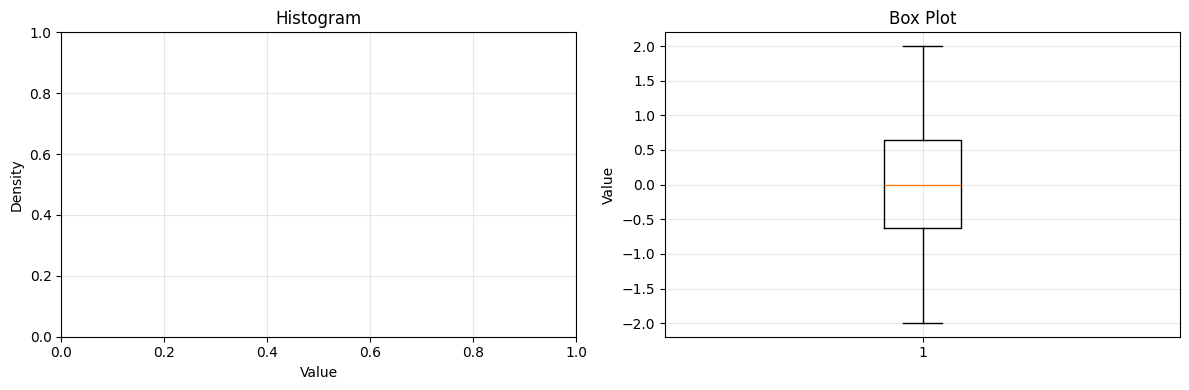

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Collect flattened values from 1000 tensor initializations
all_values = []

for _ in range(1000):
    w = torch.nn.init.trunc_normal_(torch.empty(3, 2), mean=0.0, std=1.0)
    # Flatten the tensor and add values to our collection
    flattened = w.flatten()
    all_values.extend(flattened.tolist())

# Convert to numpy array for easier analysis
all_values = np.array(all_values)

print(f"Total number of values: {len(all_values)}")
print(f"Mean: {all_values.mean():.4f}")
print(f"Standard deviation: {all_values.std():.4f}")
print(f"Min value: {all_values.min():.4f}")
print(f"Max value: {all_values.max():.4f}")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(all_values, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title('Distribution of Values from 1000 Truncated Normal Tensors (3x2)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.show()

# Also show some statistics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(all_values, vert=True)
plt.title('Box Plot')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[[-0.5596346259117126, -0.9211097359657288],
 [1.7639741897583008, 0.7137880325317383],
 [0.47829052805900574, 0.9243882894515991]]